In [1]:
!pip install pyspark

     |████████████████████████████████| 281.4 MB 32 kB/s              
  Preparing metadata (setup.py) ... - \ done
     |████████████████████████████████| 198 kB 66.7 MB/s            
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=ecba71c04231c220d2e2a06d96d82923abb23d70a5ceb108112ecd5547f33fe7
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.4
    Uninstalling py4j-0.10.9.4:
      Successfully uninstalled py4j-0.10.9.4


In [2]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType,StructField, StringType, IntegerType 
from pyspark.sql.types import ArrayType, DoubleType, BooleanType
from pyspark.sql.functions import col,array_contains
from pyspark.sql import SQLContext 
from pyspark.ml.recommendation import ALS
from pyspark.sql.functions import udf,col,when
from pyspark.sql.functions import to_timestamp,date_format
import numpy as np
import pandas as pd
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql.window import *
sc = SparkSession.builder.appName("Recommendations").config("spark.sql.files.maxPartitionBytes", 5000000).getOrCreate()
spark = SparkSession(sc)

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/04/11 15:11:51 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
#import to_read data

file_location = "../input/goodbooks-10k/to_read.csv"
file_type = "csv"

# CSV options
infer_schema = "True"
first_row_is_header = "True"
delimiter = ","

# The applied options are for CSV files. For other file types, these will be ignored.
to_read = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location)

display(to_read)

# Create Temporary Tables
to_read.createOrReplaceTempView("to_read")

DataFrame[user_id: int, book_id: int]

In [4]:
#import ratings data
file_location = "../input/goodbooks-10k/ratings.csv"
file_type = "csv"

# CSV options
infer_schema = "True"
first_row_is_header = "True"
delimiter = ","

# The applied options are for CSV files. For other file types, these will be ignored.
ratings = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location)

display(ratings)

# Create Temporary Tables
ratings.createOrReplaceTempView("ratings")

DataFrame[book_id: int, user_id: int, rating: int]

In [5]:
display(ratings)

DataFrame[book_id: int, user_id: int, rating: int]

%sql
select * from ratings

In [6]:
#import books data
file_location = "../input/goodbooks-10k/books.csv"
infer_schema = "True"
first_row_is_header = "True"
delimiter = ","

# The applied options are for CSV files. For other file types, these will be ignored.
books = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sto_readep", delimiter) \
  .load(file_location)

display(books)

# Create Temporary Tables
books.createOrReplaceTempView("books")

DataFrame[id: int, book_id: int, best_book_id: int, work_id: int, books_count: int, isbn: string, isbn13: double, authors: string, original_publication_year: double, original_title: string, title: string, language_code: string, average_rating: string, ratings_count: string, work_ratings_count: string, work_text_reviews_count: string, ratings_1: double, ratings_2: int, ratings_3: int, ratings_4: int, ratings_5: int, image_url: string, small_image_url: string]

In [7]:
#converting books data into pandas dataframe

books_df = books.toPandas()
books_df.head()

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715.0,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504.0,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,3866839,3916824,95009,456191.0,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,...,3198671,3340896,72586,60427.0,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,...,2683664,2773745,51992,86236.0,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


%sql

select * from books where original_publication_year = -1750

%sql

select original_publication_year, count(*) as count from books where original_publication_year > 1950 group by original_publication_year

In [8]:
import pandas as pd
import numpy as np
books_df.shape

(10000, 23)

In [9]:
#3sanity check
books_df = books_df[books_df.ratings_count.str.isdigit() == True]
books_df.ratings_count = books_df.ratings_count.astype('int')
#Top books with most number of ratings on goodbooks

books_df.sort_values(by = 'ratings_count', ascending = False)[['original_title','ratings_count', 'average_rating' ]][0:10]

,original_title,ratings_count,average_rating
0,The Hunger Games,4780653,4.34
1,Harry Potter and the Philosopher's Stone,4602479,4.44
2,Twilight,3866839,3.57
3,To Kill a Mockingbird,3198671,4.25
4,The Great Gatsby,2683664,3.89
5,The Fault in Our Stars,2346404,4.26
6,The Hobbit or There and Back Again,2071616,4.25
7,The Catcher in the Rye,2044241,3.79
9,Pride and Prejudice,2035490,4.24
8,Angels & Demons,2001311,3.85


In [10]:
most_ratings = books_df.sort_values(by = 'ratings_count', ascending = False)[['original_title','ratings_count', 'average_rating', 'image_url' ]][0:10]

In [11]:
import pandas as pd
from IPython.display import Image, HTML
most_ratings['img_html'] = most_ratings['image_url']\
    .str.replace(
        '(.*)', 
        '<img src="\\1" style="max-height:124px;"></img>'
    )
with pd.option_context('display.max_colwidth', 10000):
  
  display(HTML(most_ratings[['original_title', 'img_html', 'ratings_count', 'average_rating' ]].to_html(escape=False)))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  


,original_title,img_html,ratings_count,average_rating
0,The Hunger Games,,4780653,4.34
1,Harry Potter and the Philosopher's Stone,,4602479,4.44
2,Twilight,,3866839,3.57
3,To Kill a Mockingbird,,3198671,4.25
4,The Great Gatsby,,2683664,3.89
5,The Fault in Our Stars,,2346404,4.26
6,The Hobbit or There and Back Again,,2071616,4.25
7,The Catcher in the Rye,,2044241,3.79
9,Pride and Prejudice,,2035490,4.24
8,Angels & Demons,,2001311,3.85


In [12]:
books_df.head()

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715.0,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504.0,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,3866839,3916824,95009,456191.0,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,...,3198671,3340896,72586,60427.0,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,...,2683664,2773745,51992,86236.0,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


In [13]:
books_df.average_rating = books_df.average_rating.astype('float')
#Top books with top average ratings on goodbooks

books_df.sort_values(by = 'average_rating', ascending = False)[['original_title','ratings_count', 'average_rating' ]][0:10]

,original_title,ratings_count,average_rating
3627,The Complete Calvin and Hobbes,28900,4.82
861,Words of Radiance,73572,4.77
3274,None,33220,4.77
8853,Mark of the Lion Trilogy,9081,4.76
7946,None,8953,4.76
4482,It's a Magical World: A Calvin and Hobbes Coll...,22351,4.75
6360,There's Treasure Everywhere: A Calvin and Hobb...,16766,4.74
421,Complete Harry Potter Boxed Set,190050,4.74
6589,The Authoritative Calvin and Hobbes,16087,4.73
6919,The Indispensable Calvin and Hobbes: A Calvin ...,14597,4.73


In [14]:
high_rating_books = books_df.sort_values(by = 'average_rating', ascending = False)[['original_title','ratings_count','image_url', 'average_rating' ]][0:10]

In [15]:
high_rating_books['img_html'] = high_rating_books['image_url']\
    .str.replace(
        '(.*)', 
        '<img src="\\1" style="max-height:124px;"></img>'
    )
with pd.option_context('display.max_colwidth', 10000):
  
  display(HTML(high_rating_books[['original_title', 'img_html','ratings_count', 'average_rating' ]].to_html(escape=False)))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  after removing the cwd from sys.path.


,original_title,img_html,ratings_count,average_rating
3627,The Complete Calvin and Hobbes,,28900,4.82
861,Words of Radiance,,73572,4.77
3274,None,,33220,4.77
8853,Mark of the Lion Trilogy,,9081,4.76
7946,None,,8953,4.76
4482,It's a Magical World: A Calvin and Hobbes Collection,,22351,4.75
6360,There's Treasure Everywhere: A Calvin and Hobbes Collection,,16766,4.74
421,Complete Harry Potter Boxed Set,,190050,4.74
6589,The Authoritative Calvin and Hobbes,,16087,4.73
6919,The Indispensable Calvin and Hobbes: A Calvin and Hobbes Treasury,,14597,4.73


In [16]:
authors_with_most_books = pd.DataFrame(books_df.authors.value_counts()[0:10]).reset_index()
authors_with_most_books.columns = ['author', 'number_of_books']
authors_with_most_books

,author,number_of_books
0,Stephen King,60
1,Nora Roberts,59
2,Dean Koontz,47
3,Terry Pratchett,42
4,Agatha Christie,39
5,Meg Cabot,37
6,James Patterson,36
7,David Baldacci,34
8,J.D. Robb,33
9,John Grisham,33


+-------+-------+------+
|book_id|user_id|rating|
+-------+-------+------+
|      1|    314|     5|
|      1|    439|     3|
|      1|    588|     5|
|      1|   1169|     4|
|      1|   1185|     4|
+-------+-------+------+
only showing top 5 rows



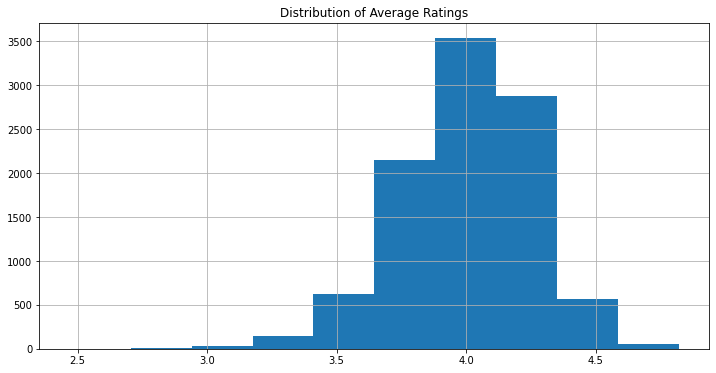

In [17]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.title('Distribution of Average Ratings')
books_df['average_rating'].hist()
display()
ratings.show(5)

In [18]:
#1 million ratings

ratings.describe().show()

+-------+-----------------+------------------+------------------+
|summary|          book_id|           user_id|            rating|
+-------+-----------------+------------------+------------------+
|  count|           981756|            981756|            981756|
|   mean|4943.275635697668|25616.759933221696|3.8565335989797873|
| stddev|2873.207414896143|15228.338825882149|0.9839408559619973|
|    min|                1|                 1|                 1|
|    max|            10000|             53424|                 5|
+-------+-----------------+------------------+------------------+



In [19]:
#Each book has 100 ratings in the ratingss dataframe

ratings.groupby('book_id').count().show()

+-------+-----+
|book_id|count|
+-------+-----+
|    148|  100|
|    463|  100|
|    471|  100|
|    496|  100|
|    833|  100|
|   1088|  100|
|   1238|  100|
|   1342|  100|
|   1580|  100|
|   1591|  100|
|   1645|  100|
|   1829|  100|
|   1959|  100|
|   2122|  100|
|   2142|  100|
|   2366|  100|
|   2659|  100|
|   2866|  100|
|   3175|  100|
|    243|  100|
+-------+-----+
only showing top 20 rows



%sql

SELECT b.original_title, r.book_id,count(*)  FROM ratings r inner join books b on b.book_id = r.book_id group by r.book_id, b.original_title having count(1)<10

In [20]:
ratings = ratings.select(ratings.user_id,
                         ratings.book_id,
                         ratings.rating.cast("double"))
ratings.show(5)

+-------+-------+------+
|user_id|book_id|rating|
+-------+-------+------+
|    314|      1|   5.0|
|    439|      1|   3.0|
|    588|      1|   5.0|
|   1169|      1|   4.0|
|   1185|      1|   4.0|
+-------+-------+------+
only showing top 5 rows



In [21]:
# Count the total number of ratings in the dataset
numerator = ratings.select("rating").count()

# Count the number of distinct Id's
num_users = ratings.select("user_id").distinct().count()
num_items = ratings.select("book_id").distinct().count()

# Set the denominator equal to the number of users multiplied by the number of items
denominator = num_users * num_items

# Divide the numerator by the denominator
sparsity = (1.0 - (numerator * 1.0)/ denominator) * 100
print("The ratings dataframe is ", "%.2f" % sparsity + "% empty.")

The ratings dataframe is  99.82% empty.


In [22]:
# Min num ratings 
print("Item with the fewest ratings: ")
ratings.groupBy("book_id").count().sort('count').show(10)

Item with the fewest ratings: 


+-------+-----+
|book_id|count|
+-------+-----+
|   7803|    8|
|   9345|   11|
|   9486|   24|
|   1935|   34|
|   9315|   36|
|   9553|   41|
|   8181|   44|
|   9260|   46|
|   9479|   47|
|   9705|   48|
+-------+-----+
only showing top 10 rows



In [23]:
# Group data by user_id, count ratings
(ratings.groupBy("user_id")
    .count()
    .filter("`count` >= 5")
    .orderBy('count', ascending=False)
    .show(n = 10))

+-------+-----+
|user_id|count|
+-------+-----+
|  12874|  200|
|  30944|  200|
|  12381|  199|
|  28158|  199|
|  52036|  199|
|  45554|  197|
|  37834|  197|
|   6630|  197|
|  15604|  196|
|  19729|  196|
+-------+-----+
only showing top 10 rows



In [24]:
(ratings.groupBy("book_id")
    .count()
    .filter("`count` > 1")
    .orderBy('count', ascending=False)
    .show(n = 10))

+-------+-----+
|book_id|count|
+-------+-----+
|    148|  100|
|    463|  100|
|    471|  100|
|    496|  100|
|    833|  100|
|   1088|  100|
|   1238|  100|
|   1342|  100|
|   1580|  100|
|   1591|  100|
+-------+-----+
only showing top 10 rows



In [25]:
(training, test) = ratings.randomSplit([0.8, 0.2])
test.show(5)

+-------+-------+------+
|user_id|book_id|rating|
+-------+-------+------+
|      7|    956|   5.0|
|      7|   1620|   5.0|
|      7|   1873|   4.0|
|      7|   1969|   5.0|
|      7|   2129|   5.0|
+-------+-------+------+
only showing top 5 rows



In [26]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row
als = ALS( userCol="user_id", itemCol="book_id", ratingCol="rating",
          coldStartStrategy="drop", nonnegative = True, implicitPrefs = False)

In [27]:
type(als)

pyspark.ml.recommendation.ALS

In [28]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator 

param_grid = ParamGridBuilder() \
            .addGrid(als.rank, [10, 50, 75, 100]) \
            .addGrid(als.maxIter, [5, 50, 75, 100]) \
            .addGrid(als.regParam, [.01, .05, .1, .15]) \
            .build()

In [29]:
# Define evaluator as RMSE
evaluator = RegressionEvaluator(metricName = "rmse", 
                                labelCol = "rating", 
                                predictionCol = "prediction")
# Print length of evaluator
print ("Num models to be tested using param_grid: ", len(param_grid))

Num models to be tested using param_grid:  64


In [30]:
# Build cross validation using CrossValidator
cv = CrossValidator(estimator = als, 
                    estimatorParamMaps = param_grid, 
                    evaluator = evaluator, 
                    numFolds = 5)
print(cv)

CrossValidator_c5d59d333529


In [31]:
model = als.fit(training)
predictions = model.transform(test)
predictions.show(n = 10)

+-------+-------+------+----------+
|user_id|book_id|rating|prediction|
+-------+-------+------+----------+
|    148|   2334|   4.0| 3.7462537|
|    148|   2700|   4.0|  3.185718|
|   1088|     94|   4.0| 4.4503756|
|   1088|    110|   4.0| 3.8567455|
|   1088|    188|   4.0| 3.7929378|
|   1088|    197|   2.0| 2.5686135|
|   1088|    228|   2.0| 2.5240974|
|   1088|    231|   3.0| 3.5306485|
|   1088|    237|   2.0| 3.3762357|
|   1088|    268|   2.0| 3.5801044|
+-------+-------+------+----------+
only showing top 10 rows



In [32]:
predictions.createOrReplaceTempView("predictions")
predictions.head()

Row(user_id=148, book_id=2334, rating=4.0, prediction=3.746253728866577)

predictions.createOrReplaceTempView("predictions")
%sql
select * from predictions

%sql
select predictions.user_id, predictions.book_id, predictions.rating, predictions.prediction, books.title from 
predictions inner join books 
ON predictions.book_id = books.id

In [33]:
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

Root-mean-square error = 0.9181826598617502


In [34]:
# Generate n recommendations for all users
ALS_recommendations = model.recommendForAllUsers(numItems = 10) # n - 10

/opt/conda/lib/python3.7/site-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


In [35]:
ALS_recommendations.show(n = 10)

+-------+--------------------+
|user_id|     recommendations|
+-------+--------------------+
|      1|[{4154, 4.394998}...|
|      6|[{2840, 4.4206657...|
|     13|[{6590, 4.381621}...|
|     16|[{4868, 4.556119}...|
|     22|[{6928, 4.5455503...|
|     26|[{8616, 4.3663516...|
|     27|[{6590, 4.792485}...|
|     28|[{8976, 4.5465574...|
|     31|[{2840, 4.082802}...|
|     34|[{7254, 3.359406}...|
+-------+--------------------+
only showing top 10 rows



In [36]:
# Temporary table
ALS_recommendations.registerTempTable("ALS_recs_temp")
clean_recs = spark.sql("""SELECT user_id,
                            movieIds_and_ratings.book_id AS book_id,
                            movieIds_and_ratings.rating AS prediction
                        FROM ALS_recs_temp
                        LATERAL VIEW explode(recommendations) exploded_table
                            AS movieIds_and_ratings""")
clean_recs.show()

/opt/conda/lib/python3.7/site-packages/pyspark/sql/dataframe.py:140: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  FutureWarning


+-------+-------+----------+
|user_id|book_id|prediction|
+-------+-------+----------+
|      1|   4154|  4.394998|
|      1|   4868|  4.310389|
|      1|   1338| 4.2751117|
|      1|   8521|  4.239498|
|      1|   4750|  4.225227|
|      1|   9842|  4.188964|
|      1|   5919| 4.1828556|
|      1|   7063|  4.163772|
|      1|   3093| 4.1505466|
|      1|   2151|  4.142167|
|      6|   2840| 4.4206657|
|      6|   4868| 4.3392906|
|      6|   9076|  4.297622|
|      6|   4336| 4.2480836|
|      6|   1265| 4.2471375|
|      6|   9222| 4.2438064|
|      6|   2149|  4.239881|
|      6|   2527|  4.236942|
|      6|   2831| 4.2348995|
|      6|   9569| 4.2321076|
+-------+-------+----------+
only showing top 20 rows



In [37]:
# Recommendations for unread books
(clean_recs.join(ratings, ["user_id", "book_id"], "left")
    .filter(ratings.rating.isNull()).show())

+-------+-------+----------+------+
|user_id|book_id|prediction|rating|
+-------+-------+----------+------+
|      1|   1338| 4.2751117|  null|
|      1|   4154|  4.394998|  null|
|      1|   4750|  4.225227|  null|
|      2|   4346| 4.7603173|  null|
|      2|   8663|  4.894432|  null|
|      4|    635|  5.385114|  null|
|      4|   6392|  5.407191|  null|
|      4|   8337|  5.395429|  null|
|      5|   7063| 4.7881355|  null|
|      6|   1265| 4.2471375|  null|
|      6|   2149|  4.239881|  null|
|      6|   2840| 4.4206657|  null|
|      7|   1788|  4.612254|  null|
|      7|   9209| 4.6826725|  null|
|      8|     28|  4.994852|  null|
|      8|   4765|  5.216422|  null|
|      8|   6089|  5.096838|  null|
|      8|   9716| 5.0250697|  null|
|     10|   4721| 5.0159583|  null|
|     10|   6220|  5.035681|  null|
+-------+-------+----------+------+
only showing top 20 rows



In [38]:
new_books = (clean_recs.join(ratings, ["user_id", "book_id"], "left")
    .filter(ratings.rating.isNull()))
print(new_books.count())

521618


In [39]:
new_books.show(5)

+-------+-------+----------+------+
|user_id|book_id|prediction|rating|
+-------+-------+----------+------+
|      1|   1338| 4.2751117|  null|
|      1|   4154|  4.394998|  null|
|      1|   4750|  4.225227|  null|
|      2|   4346| 4.7603173|  null|
|      2|   8663|  4.894432|  null|
+-------+-------+----------+------+
only showing top 5 rows



In [40]:
to_read.show(5)

+-------+-------+
|user_id|book_id|
+-------+-------+
|      1|    112|
|      1|    235|
|      1|    533|
|      1|   1198|
|      1|   1874|
+-------+-------+
only showing top 5 rows



In [41]:
# Create Temporary Tables
new_books.createOrReplaceTempView("new_books")
print(new_books.count())

521618


In [42]:
print(to_read.count())

912705


In [43]:
# Create Temporary Tables
to_read.createOrReplaceTempView("to_read")
recommendations = new_books.join(to_read,
                              on = ["user_id", "book_id"], 
                              how = "inner")
print(recommendations.show())

+-------+-------+----------+------+
|user_id|book_id|prediction|rating|
+-------+-------+----------+------+
|    162|   3586| 3.9156423|  null|
|    305|   7401|  3.368175|  null|
|    438|    143| 3.8858554|  null|
|   1147|   5276| 3.5514288|  null|
|   1266|   2840| 4.4482207|  null|
|   1827|   3491| 4.5974245|  null|
|   1959|   3491|  3.452016|  null|
|   2122|   1146| 3.7598944|  null|
|   2129|   4256|  4.665878|  null|
|   2312|   1471| 5.0848017|  null|
|   3391|   1265| 3.1481571|  null|
|   4062|   9222| 4.2084765|  null|
|   4400|   4868| 4.9333487|  null|
|   4520|   4344| 3.8911712|  null|
|   4804|    192| 4.1170177|  null|
|   5083|   2844|  4.176055|  null|
|   5083|   7305| 4.2788925|  null|
|   5800|    481| 5.1571956|  null|
|   7112|    717| 3.9358373|  null|
|   7375|   2590| 4.8764005|  null|
+-------+-------+----------+------+
only showing top 20 rows

None


In [44]:
print(recommendations.count())

694


In [45]:
(recommendations
     .withColumn('pred_trunc', recommendations.prediction.substr(1,1))
     .groupby('pred_trunc')
     .count()
     .sort('pred_trunc')
    .show())

+----------+-----+
|pred_trunc|count|
+----------+-----+
|         1|    2|
|         2|   15|
|         3|  114|
|         4|  386|
|         5|  176|
|         6|    1|
+----------+-----+



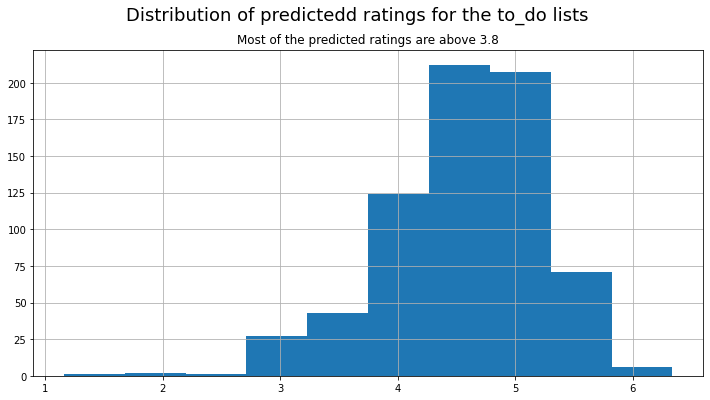

In [46]:
# Create Temporary Tables
recommendations.createOrReplaceTempView("recommendations")
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.title('Most of the predicted ratings are above 3.8', fontsize = 12)
plt.suptitle('Distribution of predictedd ratings for the to_do lists', fontsize = 18)
rec = recommendations.toPandas()
rec['prediction'].hist()
display()